## Assignment 10: Active Learning

#### Introduction
In this lab, Gaussian Process Regression with an RBF kernel was used to perform prediction on FWHM of Cr-Ti-Zn alloy systems.

**Goal:** 
The goal of this lab is to demonstrate the ability to use active learning.

**Approach:** 
A dataframe containing the ground truth will be sampled on the locations proposed by an acquisition function, simulating how experimental data is obtained. 

In [1]:
import numpy as np
import numpy.matlib as nm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import seaborn as sb
from tqdm import tqdm

### 1. Open data and perform cleaning

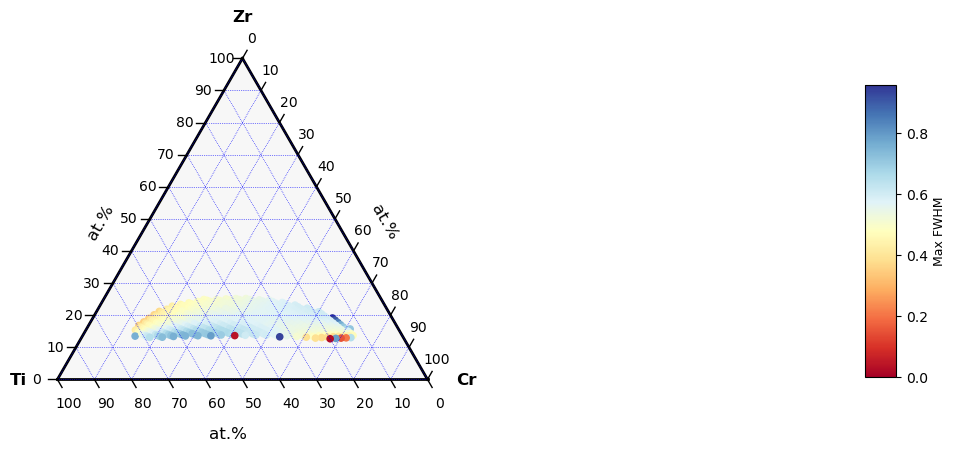

In [2]:
from CustomFunctions import df_plot_ternary

elements = ['Cr', 'Ti', 'Zr']

fig, ax = plt.subplots(1, 2, figsize = (9, 4))
fig.tight_layout(pad = 0)

df = pd.read_csv('Metallic Glass Data.csv')

# plotting 
df_plot_ternary(df, df.loc[:, 'MaxFWHM'], 'Max FWHM', ax = ax[0], cmap = plt.cm.RdYlBu)

In [3]:
# dff = df.copy()
# dff.insert(0, 'formula', 'Ti' + dff['Ti'].astype(str) + 'Cr' + dff['Cr'].astype(str) + 'Zr' + dff['Zr'].astype(str))

# from matminer.featurizers.conversions import StrToComposition
# dff = StrToComposition().featurize_dataframe(dff, 'formula')

# from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency, ElectronegativityDiff
# from matminer.featurizers.composition import BandCenter, TMetalFraction, CohesiveEnergyMP, IonProperty

# dff = AtomicPackingEfficiency().featurize_dataframe(dff, col_id='composition')
# dff = Miedema().featurize_dataframe(dff, col_id='composition')
# dff = Meredig().featurize_dataframe(dff, col_id='composition')
# dff = WenAlloys().featurize_dataframe(dff, col_id='composition')

# dff = BandCenter().featurize_dataframe(dff, col_id='composition')
# dff = TMetalFraction().featurize_dataframe(dff, col_id='composition')

# dff.to_excel('dff.xlsx', index = False)

before dropping there are  41  features
THRESHOLD:  0.9


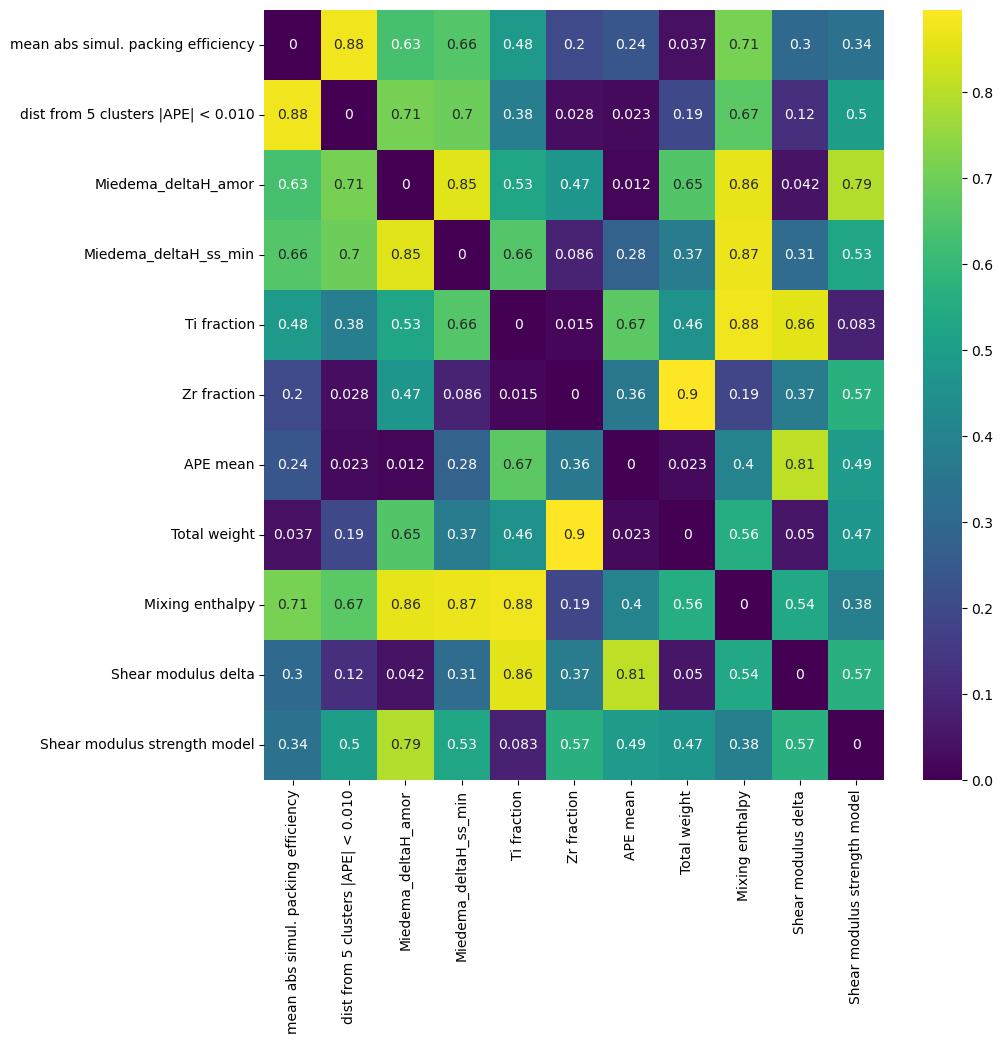

after dropping there are  11  features


In [10]:
dff = pd.read_excel('dff.xlsx')

# drop the rows with nan
dff = dff.dropna()
# drop the column if the entire column is the same value
dff = dff.loc[:, dff.apply(pd.Series.nunique) != 1]

features = dff.iloc[:, 6:]
# drop the non-numerical columns from the dataframe
non_numeric_cols = features.select_dtypes(exclude='number').columns
features = features.drop(columns=non_numeric_cols)
print('before dropping there are ', features.shape[1], ' features')

from CustomFunctions import ranked_drop # perform correlation analysis and drop the most correlated features
features = ranked_drop(features, 0.9, plot=True)
print('after dropping there are ', features.shape[1], ' features')

# from /features, define the ground truth
ground_truth = pd.concat([features, dff['MaxFWHM']], axis=1)

# from /features, define prediction grid
X_pred_grid = features.values

scaler = StandardScaler().fit(X_pred_grid)
X_pred_grid_std = scaler.transform(X_pred_grid)

In [121]:
features.to_excel('features.xlsx', index=False)

In [107]:
# Define generalacquisition function (can be exploit/random/explore)
def acq_new(X, y, y_std, mask, n_observ = 1, n_std = 2, top = 1, privilege = 10):
    '''
    This function first ranks the points in the prediction grid based on mean plus a *n_std* number of standard deviation, take the top *top* rows, and randomly select the rest with weighted possibility.
    input:
    X: loction of predicted points
    y: corresponding predicted y values
    y_std: corresponding predicted y_std values
    mask: ndarray with same length as X, indicating where samples have been taken out
    
    parameters: for tuning, incl:
    1. n_observ: the number of points to be observed next,
    2. n_std: (0 ~ 3) balances exploitation vs. exploration. Default is the LCB criteria: mean - 2*std. Zero value -> exploitation, very large value -> exploration
    3. top: (0 ~ 5 ususally) the top seeds that will be automatically from the top-ranked points. Default 1 is equivalent to sampling 1 point from the top-ranked points.
    4. privilege: (0 ~ 1000) the higher the privilege, the more likely the top-ranked points will be sampled. Default 10 is give high ranked reasonable privilege to be sampled. 0 means perfect random sampling
    
    output:
    X_next: the proposed new locations to observe'''

    ### 0. initialize the df to store the input
    # make a input_df to store X. This way avoid incessent indexing across input variables
    input_df = pd.DataFrame(X)

    input_df['y_pred'], input_df['y_std'] = y, y_std
    # make a new column to store the upper confidence bound of the confidence interval
    input_df['UCB'] = input_df['y_pred'] + n_std * input_df['y_std']
    input_df = input_df[~mask]

    length = len(input_df)

    ### 1. select top performers (by UCB)
    # sort the df by UCB, and return the the ones with higest UCB
    sorted_index = input_df.sort_values('UCB', ascending=True).index.to_numpy()
    top_index = sorted_index[:top]
    bottom_index = sorted_index[top:]

    if n_observ > top:
        ### 2. select the lucky losers (by weighted random sampling)
        n_lucky = int(n_observ - top) # determine the number of lucky losers
        weights = np.power(np.linspace(1, 0, length-top), privilege) 
        weights = weights/weights.sum()  
        
        lucky_indices = np.random.choice(bottom_index, 
                                size=n_lucky, replace=False, p=weights)
        
        index = np.concatenate(top_index, lucky_indices)
    else:
        index = top_index
    

    return index

## Using GPR to perform active learning

### 1. Try random selection
the acquisition function has been adjusted to simulate random selection:
- _top = 0_, so the top-ranked prediction point will not be automatically selected, and 
- _privilege = 0_ so each row has equal likelihood of being sampled, regardless of where the row ranks

In [75]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

# 0. define kernel
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-7, 1e-4))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e0))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

error_list = []

# run random 5 times
for trial in tqdm(range(5)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 5, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    error = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)
        error.append(mse)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 1, n_std = 0, privilege = 0, top = 0) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        y_next = ground_truth.iloc[index, -1].values

        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

    # record the error curve in this trial
    error_list.append(error)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

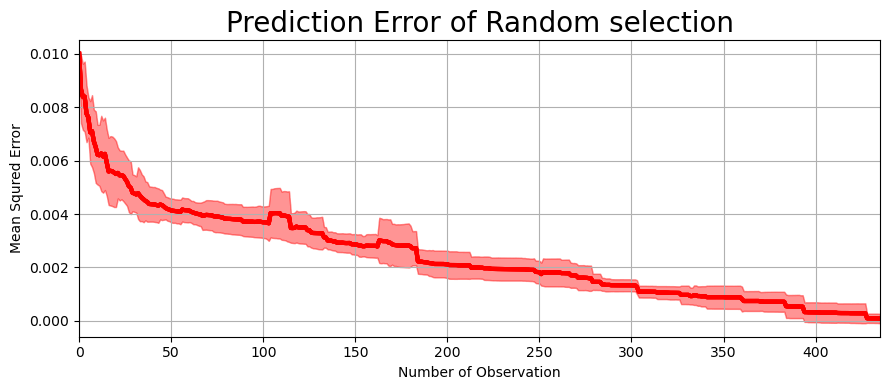

In [96]:
all_error = np.array(error_list)
mean = np.mean(all_error, axis=0)
sdev = np.std(all_error, axis=0)

fig, ax = plt.subplots(1, 1, figsize = (9, 4))
for error in error_list:
    ax.plot(mean, color='r', linewidth = 3)
    ax.fill_between(np.arange(436), mean-sdev, mean+sdev, alpha = 0.1, color = 'r')
    ax.set_xlabel('Number of Observation')
    ax.set_ylabel('Mean Squred Error')
    ax.margins(x=0)
    ax.set_title('Prediction Error of Random selection', fontsize = 20)
    ax.grid(); fig.tight_layout()
    # ax.set_yscale('log')

### 2. Try expoitation
the acquisition function has been adjusted to simulate standard exploitation:
- **_n-std = 0_** the basis to rank the row is mean+0*std, which means the values with the highest predicted mean will be observed first.
- **_top = 1_**, so the top-ranked prediction point will not be automatically selected, and 


In [108]:

# 0. define kernel
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-7, 1e-4))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e0))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

# error_list2 = []

# run 5 times
for trial in tqdm(range(2)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 5, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    error = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)
        error.append(mse)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 1, n_std = 0, top = 1, privilege = 0) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        y_next = ground_truth.iloc[index, -1].values

        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

    # record the error curve in this trial
    error_list2.append(error)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warning

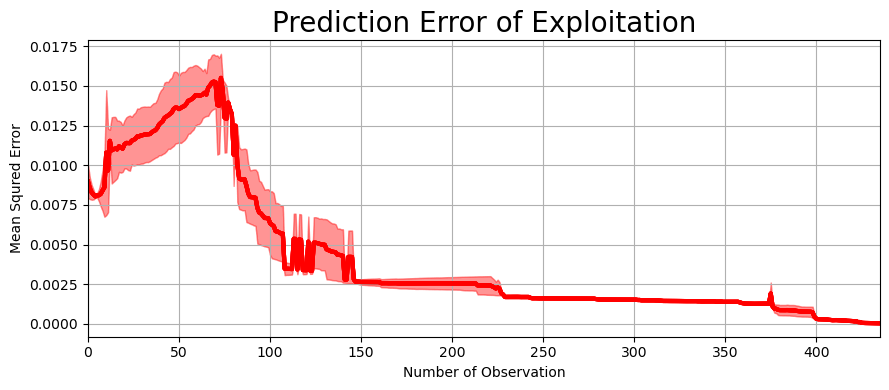

In [113]:
all_error = np.array(error_list2)
mean = np.mean(all_error, axis=0)
sdev = np.std(all_error, axis=0)

fig, ax = plt.subplots(1, 1, figsize = (9, 4))
for error in error_list:
    ax.plot(mean, color='r', linewidth = 3)
    ax.fill_between(np.arange(436), mean-sdev, mean+sdev, alpha = 0.1, color = 'r')
    ax.set_xlabel('Number of Observation')
    ax.set_ylabel('Mean Squred Error')
    ax.margins(x=0)
    ax.set_title('Prediction Error of Exploitation', fontsize = 20)
    ax.grid(); fig.tight_layout()
    # ax.set_yscale('log')

### 2. Try Exploration
the acquisition function has been adjusted to simulate standard exploitation:
- **_n-std = 5_** the basis to rank the row is mean+5*std, which means the values with the highest predicted mean will be observed first.
- **_top = 1_**, so the top-ranked prediction point will not be automatically selected, and 


In [110]:
# 0. define kernel
kernel1 = RBF(length_scale=1e-6, length_scale_bounds=(1e-7, 1e-4))
kernel2 = RBF(length_scale=1, length_scale_bounds=(1e-4, 1e0))

kernel = 0.6*kernel1 + 0.4*kernel2
GPR = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=10, random_state=0, normalize_y=True)

error_list3 = []

# run 5 times
for trial in tqdm(range(2)):
    # 1. select a small subset of data as initial training point
    train_df = ground_truth.sample(n = 5, random_state = trial, replace=False)
    # 1.1 also initialize the list of all observed indices, currently only five
    indices = train_df.index.to_list()

    X = train_df.iloc[:, :-1].values
    y = train_df.iloc[:, -1].values

    error = []

    mask = np.zeros((X_pred_grid.shape[0],), dtype=bool) # store the index of the observed points
    mask[indices] = True
    # loop: while not all data has been used to train
    for i in tqdm(range(len(ground_truth)-5)):

        # 1. fit the model
        X_std = scaler.transform(X)
        GPR.fit(X_std, y)

        # 3. predict the y values for the prediction grid
        y_pred_mean, y_pred_std = GPR.predict(X_pred_grid_std, return_std=True)

        # 3.1 performance notes: calculate the RMSE between the predicted y and the ground truth y
        mse = mean_squared_error(y_pred_mean, ground_truth.iloc[:, -1].values)
        error.append(mse)

        # 4. find the index of the next point to observe
        index = acq_new(X_pred_grid, y_pred_mean, y_pred_std, mask, n_observ = 1, n_std = 10, top = 1, privilege = 0) 
        
        # 4.1 create a boolean mask, to be used in the next loop (to avoid duplicate observations)
        mask[index] = True

        # 5. observe the X, y value of the next point
        X_next = X_pred_grid[index, :]
        y_next = ground_truth.iloc[index, -1].values

        # 6. append to training data
        X = np.append(X, X_next, axis=0); y = np.append(y, y_next, axis=0)

    # record the error curve in this trial
    error_list3.append(error)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warning

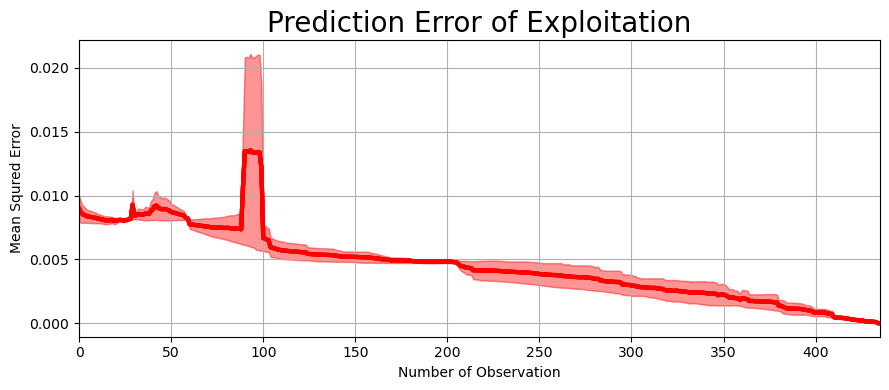

In [114]:
all_error = np.array(error_list3)
mean = np.mean(all_error, axis=0)
sdev = np.std(all_error, axis=0)

fig, ax = plt.subplots(1, 1, figsize = (9, 4))
for error in error_list:
    ax.plot(mean, color='r', linewidth = 3)
    ax.fill_between(np.arange(436), mean-sdev, mean+sdev, alpha = 0.1, color = 'r')
    ax.set_xlabel('Number of Observation')
    ax.set_ylabel('Mean Squred Error')
    ax.margins(x=0)
    ax.set_title('Prediction Error of Exploitation', fontsize = 20)
    ax.grid(); fig.tight_layout()
    # ax.set_yscale('log')

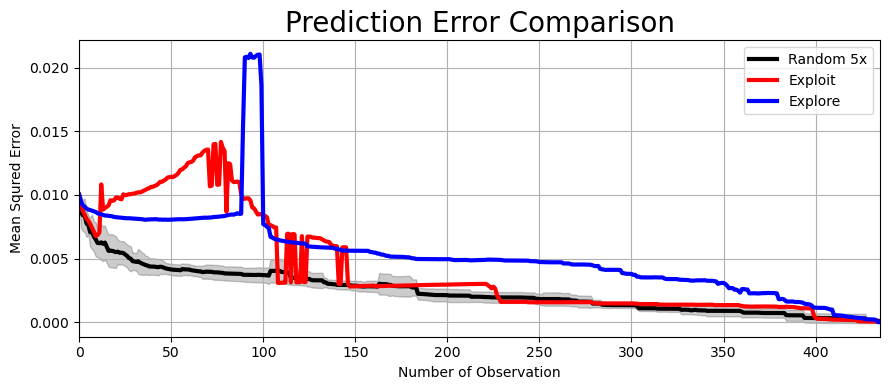

In [120]:
all_error = np.array(error_list)
mean = np.mean(all_error, axis=0)
sdev = np.std(all_error, axis=0)

fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.plot(mean, color='k', linewidth = 3, label = 'Random 5x')
ax.fill_between(np.arange(436), mean-sdev, mean+sdev, alpha = 0.2, color = 'k')
ax.set_xlabel('Number of Observation')
ax.set_ylabel('Mean Squred Error')
ax.margins(x=0)
ax.set_title('Prediction Error Comparison', fontsize = 20)
ax.grid(); fig.tight_layout()

ax.plot(error_list2[1], color='r', linewidth = 3, label = 'Exploit')
ax.plot(error_list3[1], color='b', linewidth = 3, label = 'Explore')
ax.legend()

## Reflection

The overall learning rate for both acquisition policies was slower than that of random. The exploitation error went up in the earlier iterations, as it prioritizes observing the ones with largest FWHM first, and training on values with large FWHM gives it a wrong picture of what the overall FWHM is like. The exploration is also slower than random.

Referring to the performance curve of the random sample, I would have stopped at the 50th iteration since the first 50 iteration was when the error dropped the fastest.

ChatGPT was not very helpful in fitting the data. I attempted to make the data more interpretable by cutting down the number of rows and columns. The best it did was producing reasonable-looking predctions, but are most likely made-up numbers.

### ChatGPT 

#### Attempt 1: 
I pass it my entire (selected 11 features) features set and ask for its prediction. The problem being, it seems to lose its memory of what it need to do after seeing the immensity of the dataset.
<img src='Method 1.png' width='800' align='left' />

And when I try to help by suggesting that it arranges the data into table, it is trying to generate random number in a random table.


<img src='Method 1.2.png' width='800' align='left' />
So Method 1 did not work

#### Attemp 2: 
I tried to give it less features and less rows, and it just doesn't seem to understand what I want quite well. This picture shows that it is not even sure if I have passed my training data or not.
<img src='Method 2.png' width='800' align='left' />

When it compiled the data into the coding snippet, it did not proceed to train the data, but just stopped there.

<img src='Method 2.2.png' width='800' align='left' />

So method 2 failed.

#### Attempt 3

I gave it an overall outline of what we need to do before passing the data, which is again, a small traing set. 
<img src='Method 3.png' width='800' align='left' />

This time, it managed to produce some reasonable looking prediction. Most notable of all was that it predicted the last row having a smaller MaxFWHM, as is the true value:
0.525947777
0.536130323
0.54684807
0.561790558
0.365453018

<img src='Method 3.2.png' width='800' align='left' />

We can still see that it predicts lower and lower value, so the results still looks suspecious. But it seems like a good starting point.

#### Attempt 4

Following previous success, I did it again with more training data. This time, its got lost about "what to do" again 

<img src='Method 4.png' width='800' align='left' />

and the prediction it gave was nonsense

<img src='Method 4.2.png' width='800' align='left' />

So overall, it did not give the prediction after 4 attempts.